https://github.com/Beckschen/TransUNet/blob/main/datasets/dataset_synapse.py

In [1]:
from __future__ import division
import nibabel as nib
import numpy as np
import nibabel as nib
import glob
import os
from tqdm import tqdm
from scipy.ndimage.morphology import binary_erosion, binary_fill_holes

from matplotlib import pyplot as plt

## Auxiliary functions 

In [2]:
def hu_to_grayscale(volume):
    volume = np.clip(volume, -512, 512)
    mxval  = np.max(volume)
    mnval  = np.min(volume)
    im_volume = (volume - mnval)/max(mxval - mnval, 1e-3)
    im_volume = im_volume
    return im_volume *255

def get_mask_alung(vol):
    vol_im = np.where(vol>0, 1, 0)
    shp    = vol.shape
    around_lung = np.zeros((shp[0], shp[1], shp[2]), dtype=np.float32)
    for idx in range(shp[0]):
        around_lung[idx, :, :] = binary_erosion(vol_im[idx], structure=np.ones((15,15))).astype(vol_im.dtype)
    return around_lung

def get_mask(segmentation):
    shp    = segmentation.shape
    lung = np.zeros((shp[0], shp[1], shp[2]), dtype=np.float32)
    lung[np.equal(segmentation,255)] = 255
    return lung
    
def get_FOV(around_lung, lung):
    FOV = np.where((around_lung + lung)>0, 1, 0)
    for idx in range(FOV.shape[0]):
        FOV[idx, :, :] = binary_fill_holes(FOV[idx, :, :], structure=np.ones((5,5))).astype(FOV.dtype)
    return FOV

def return_axials(vol, seg):
    # Prepare segmentation and volume
    vol = np.asanyarray(vol.dataobj)
    seg = np.asanyarray(seg.dataobj)
    seg = seg.astype(np.int32)
    
    # Convert to a visual format
    vol_ims = hu_to_grayscale(vol)
    lung    = get_mask(seg)
    around_lung = get_mask_alung(vol_ims)
    FOV = get_FOV(around_lung, lung)
    around_lung = np.where((FOV - lung) >0, 1, 0)

    return vol_ims, lung, around_lung, FOV

# Preprocessing stage

In [3]:
# Define Train data and mask
Data_train  = []
Mask_train  = []
Maska_train = []
FOV_train   = []


Tr_add = '/home/staff/azad/deeplearning/datasets/lung/archive/3d_images'

Tr_list = glob.glob(Tr_add+'/*.gz')

In [4]:
idx_count = 1
for idx in tqdm(range(len(Tr_list))):
    b = Tr_list[idx]
    a = b[len(Tr_add)+1:len(Tr_add)+4]
    if a=='IMG':
        a = b[len(Tr_add)+5:len(b)]
        add = (Tr_add+'/MASK_' + a) 
        vol = nib.load(Tr_list[idx])
        seg = nib.load(add)
        # Get the axials images and corresponding masks
        vol_ims, lung, around_lung, FOV = return_axials(vol, seg)          
        segmentation  = np.asanyarray(seg.dataobj)
        # Insert samples to the Train data, which has the segmentation label
        for idx in range(vol.shape[0]):
            if not np.sum(np.sum(np.sum(segmentation[idx, :, :]))) == 0: 
                Data_train.append(vol_ims [idx, :, :])
                Mask_train.append(lung[idx, :, :])
                Maska_train.append(around_lung[idx, :, :])               
                FOV_train.append(FOV[idx, :, :])               
        idx_count += 1

100%|██████████| 8/8 [01:07<00:00,  8.45s/it]


In [5]:
# list to array
data_train = np.array(Data_train)
mask_train = np.array(Mask_train)
maska_train = np.array(Maska_train)
fov_train = np.array(FOV_train)

# We use 50% of the data for training, 20% for validation, and 30% for test
data_len = len(data_train)

tr_start = 0
vl_start = int(data_len * 0.5)
te_start = int(data_len * 0.7)

print(f'length of dataset:\t{data_len}\n{35*"-"}')
print(f'training indices:\t{0}-{vl_start-1}')
print(f'validation indices:\t{vl_start}-{te_start-1}')
print(f'test indices:\t\t{te_start}-{data_len-1}')

tr_imgs = data_train[0       :vl_start,:,:]
vl_imgs = data_train[vl_start:te_start,:,:]
te_imgs = data_train[te_start:        ,:,:]

tr_msks = mask_train[0       :vl_start,:,:]
vl_msks = mask_train[vl_start:te_start,:,:]
te_msks = mask_train[te_start:        ,:,:]

tr_mskas = maska_train[0       :vl_start,:,:]
vl_mskas = maska_train[vl_start:te_start,:,:]
te_mskas = maska_train[te_start:        ,:,:]

tr_fovs = fov_train[0       :vl_start,:,:]
vl_fovs = fov_train[vl_start:te_start,:,:]
te_fovs = fov_train[te_start:        ,:,:]

length of dataset:	1021
-----------------------------------
training indices:	0-509
validation indices:	510-713
test indices:		714-1020


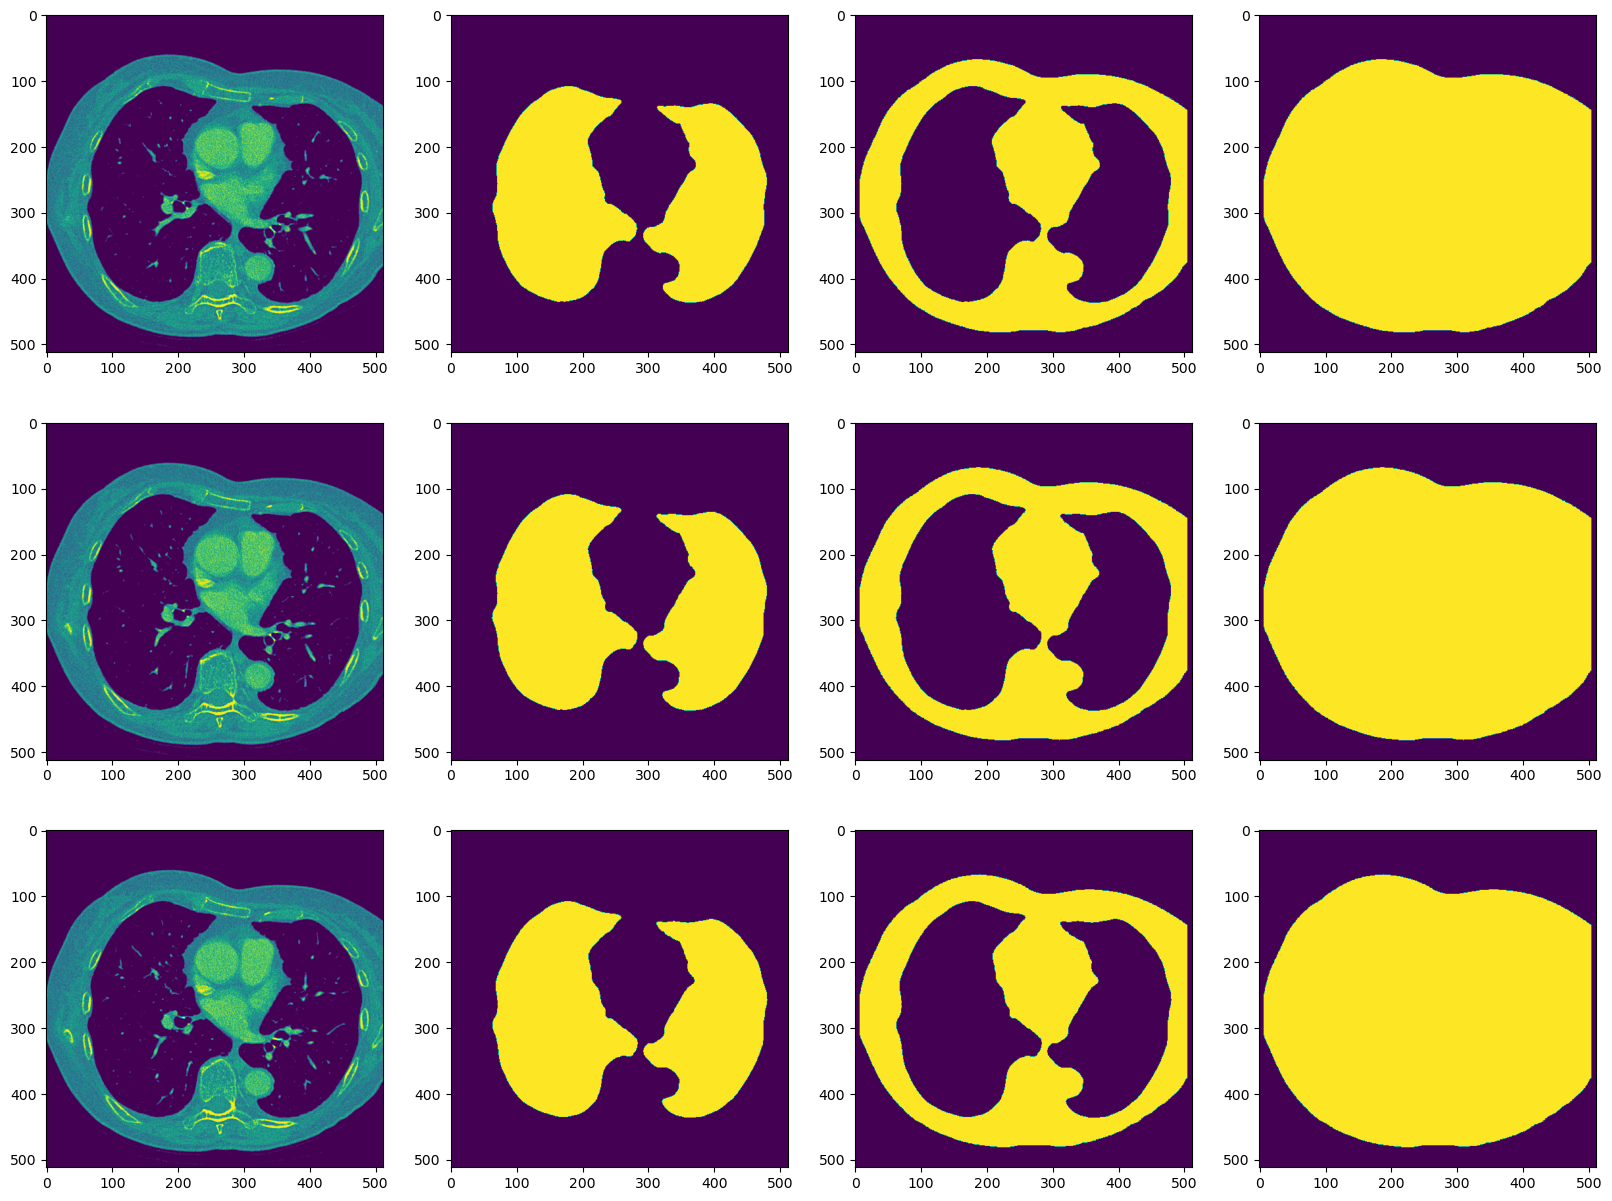

In [6]:
_, axs = plt.subplots(3, 4, figsize=(4*5, 3*5))

for i in range(3):
    axs[i, 0].imshow(vl_imgs[i])
    axs[i, 1].imshow(vl_msks[i])
    axs[i, 2].imshow(vl_mskas[i])
    axs[i, 3].imshow(vl_fovs[i])
plt.show()

In [7]:
save_pd_dir = './dataset/lung-2d/processed_data/'
if not os.path.exists(save_pd_dir):
    os.makedirs(save_pd_dir)
    
# save processed data
np.save(f"{save_pd_dir}/tr_X", tr_imgs)
np.save(f"{save_pd_dir}/vl_X", vl_imgs)
np.save(f"{save_pd_dir}/te_X", te_imgs)
np.save(f"{save_pd_dir}/tr_M", tr_msks)
np.save(f"{save_pd_dir}/vl_M", vl_msks)
np.save(f"{save_pd_dir}/te_M", te_msks)

# save additional data
np.save(f"{save_pd_dir}/tr_Ma", tr_mskas)
np.save(f"{save_pd_dir}/vl_Ma", vl_mskas)
np.save(f"{save_pd_dir}/te_Ma", te_mskas)
np.save(f"{save_pd_dir}/tr_FOV", tr_fovs)
np.save(f"{save_pd_dir}/vl_FOV", vl_fovs)
np.save(f"{save_pd_dir}/te_FOV", te_fovs)

In [3]:
!ls -lh './dataset/lung-2d/processed_data/'

total 0


# Dataset

In [4]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms, utils
from torchvision.io import read_image
from torchvision.io.image import ImageReadMode
from PIL import Image

## Save processed data

In [26]:
class Lung2dDataset(Dataset):
    def __init__(self, processed_data_dir, mode, 
                 raw_data_dir=None, force_replace=False, 
                 img_transform=None, msk_transform=None, verbose=True):
        self.img_transform = img_transform
        self.msk_transform = msk_transform
        self.mode = mode
        self.raw_data_dir = raw_data_dir
        self.processed_data_dir = processed_data_dir
        self.force_replace = force_replace
        self.verbose = verbose
        
        if not mode in ["train", "validation", "test"]:
            raise ValueError("mode should be one of this list: ['train', 'test', 'validation']")

        self.__prepare_dataset()
        self.__load_dataset()
        
    def __len__(self):
        # imgs shape: [C, N, d0, d1]
        return self.imgs.shape[1]

    
    def __getitem__(self, idx):
        img = self.imgs[:, idx, :, :]
        msk = self.msks[:, idx, :, :]
        
        if self.img_transform:
            img = self.img_transform(img)
            img = (img - img.min())/(img.max() - img.min())
        if self.msk_transform:
            msk = self.msk_transform(msk)
            msk = (msk - msk.min())/(msk.max() - msk.min())
        
        sample = {'image':img, 'mask':msk, 'id':idx}
        return sample

        
    def __load_dataset(self):
        # save processed data
        if self.mode == "train":
            self.imgs = np.load(f"{self.processed_data_dir}/tr_X.npy")
            self.msks = np.load(f"{self.processed_data_dir}/tr_M.npy")
        elif self.mode == "test":
            self.imgs = np.load(f"{self.processed_data_dir}/te_X.npy")
            self.msks = np.load(f"{self.processed_data_dir}/te_M.npy")
        else: # validation
            self.imgs = np.load(f"{self.processed_data_dir}/vl_X.npy")
            self.msks = np.load(f"{self.processed_data_dir}/vl_M.npy")
            
        self.imgs = torch.unsqueeze(torch.Tensor(self.imgs), 0)
        self.msks = torch.unsqueeze(torch.Tensor(self.msks), 0)
        

    def __prepare_dataset(self):
        if not self.raw_data_dir:
            self.raw_data_dir = '/home/staff/azad/deeplearning/datasets/lung/archive/3d_images'
        if not self.processed_data_dir:
            self.processed_data_dir = './dataset/lung-2d/processed_data'

        save_pd_dir = self.processed_data_dir
        data_dir = self.raw_data_dir
        force_replace = self.force_replace
        
        # check if already exist
        if not os.path.exists(save_pd_dir):
            os.makedirs(save_pd_dir)
        else:
            # ---> here should be refactor
            if len(glob.glob(f"{save_pd_dir}/*.npy"))>11:
                if self.verbose:
                    print(f'lung {self.mode} dataset has already prepared and stored in: {self.processed_data_dir}')
                if not force_replace:
                    return
                if self.verbose:
                    print('forced to reprocess...\n')
            if self.verbose:
                print(f'preprocessed lung dataset is not found in {self.processed_data_dir}!')
                print(f'raw data directory: {self.raw_data_dir}')
                print(f'\npreparing lung dataset...')
                print(40*'-')
    
        instance_fps = glob.glob(data_dir+'/IMG_*.nii.gz')
        instance_ids = [n.split('/')[-1].split(".")[0].split('IMG_')[1] for n in instance_fps]
        
        if self.verbose:
            print(f'data dir:\n\t{data_dir}')
            print(f'instance file pathes:')
            print("\t"+"\n\t".join(instance_fps))
            print(f'instance ids:\n\t{instance_ids}')

        # Define Train data and mask
        tr_data = []
        tr_mask = []
        tr_maska = []
        tr_fov = []

        for number, instance_id in tqdm(enumerate(instance_ids)):
            vol = nib.load(f"{data_dir}/IMG_{instance_id}.nii.gz")
            seg = nib.load(f"{data_dir}/MASK_{instance_id}.nii.gz")

            # Get the axials images and corresponding masks
            vol_ims, lung, around_lung, FOV = self.__return_axials(vol, seg)          
            segmentation = np.asanyarray(seg.dataobj)
            
            # Find non empty mask indices
            idxs = [i for i in range(vol.shape[0]) if segmentation[i,:,:].any()]
            
            tr_data = vol_ims[idxs,:,:] if not len(tr_data) else np.concatenate([tr_data, vol_ims[idxs,:,:]], axis=0)
            tr_mask = lung[idxs,:,:] if not len(tr_mask) else np.concatenate([tr_mask, lung[idxs,:,:]], axis=0)
            tr_maska = around_lung[idxs,:,:] if not len(tr_maska) else np.concatenate([tr_maska, around_lung[idxs,:,:]], axis=0)
            tr_fov = FOV[idxs,:,:] if not len(tr_fov) else np.concatenate([tr_fov, FOV[idxs,:,:]], axis=0)

        # We use 50% of the data for training, 20% for validation, and 30% for test
        data_len = len(tr_data)

        tr_start = 0
        vl_start = int(data_len * 0.5)
        te_start = int(data_len * 0.7)
        
        if self.verbose:
            print(f'length of dataset:\t{data_len}\n{35*"-"}')
            print(f'\ttraining indices:\t{0}-{vl_start-1}')
            print(f'\tvalidation indices:\t{vl_start}-{te_start-1}')
            print(f'\ttest indices:\t\t{te_start}-{data_len-1}')

        tr_imgs = tr_data[0       :vl_start,:,:]
        vl_imgs = tr_data[vl_start:te_start,:,:]
        te_imgs = tr_data[te_start:        ,:,:]

        tr_msks = tr_mask[0       :vl_start,:,:]
        vl_msks = tr_mask[vl_start:te_start,:,:]
        te_msks = tr_mask[te_start:        ,:,:]

        tr_mskas = tr_maska[0       :vl_start,:,:]
        vl_mskas = tr_maska[vl_start:te_start,:,:]
        te_mskas = tr_maska[te_start:        ,:,:]

        tr_fovs = tr_fov[0       :vl_start,:,:]
        vl_fovs = tr_fov[vl_start:te_start,:,:]
        te_fovs = tr_fov[te_start:        ,:,:]

        if self.verbose:
            print(f'\tsaving processed data...')
        # save processed data
        np.save(f"{save_pd_dir}/tr_X", tr_imgs)
        np.save(f"{save_pd_dir}/vl_X", vl_imgs)
        np.save(f"{save_pd_dir}/te_X", te_imgs)
        np.save(f"{save_pd_dir}/tr_M", tr_msks)
        np.save(f"{save_pd_dir}/vl_M", vl_msks)
        np.save(f"{save_pd_dir}/te_M", te_msks)
        
        if self.verbose:
            print(f'\tsaving additional processed data...')
        # save additional data
        np.save(f"{save_pd_dir}/tr_Ma", tr_mskas)
        np.save(f"{save_pd_dir}/vl_Ma", vl_mskas)
        np.save(f"{save_pd_dir}/te_Ma", te_mskas)
        np.save(f"{save_pd_dir}/tr_FOV", tr_fovs)
        np.save(f"{save_pd_dir}/vl_FOV", vl_fovs)
        np.save(f"{save_pd_dir}/te_FOV", te_fovs)
        
        if self.verbose:
            print(f'preprocessing data finished.')
            print(f'all results saved in: {self.processed_data_dir}', '\n')
            
                
    def __hu_to_grayscale(self, volume):
        volume = np.clip(volume, -512, 512)
        mxval  = np.max(volume)
        mnval  = np.min(volume)
        im_volume = (volume - mnval)/max(mxval - mnval, 1e-3)
        im_volume = im_volume
        return im_volume * 255
    
    def __get_mask_alung(self, vol):
        vol_im = np.where(vol > 0, 1, 0)
        shp    = vol.shape
        around_lung = np.zeros((shp[0], shp[1], shp[2]), dtype=np.float32)
        for idx in range(shp[0]):
            around_lung[idx, :, :] = binary_erosion(
                vol_im[idx], structure=np.ones((15,15))
            ).astype(vol_im.dtype)
        return around_lung
    
    def __get_mask(self, segmentation):
        shp    = segmentation.shape
        lung = np.zeros((shp[0], shp[1], shp[2]), dtype=np.float32)
        lung[np.equal(segmentation,255)] = 255
        return lung
    
    def __get_FOV(self, around_lung, lung):
        FOV = np.where((around_lung + lung)>0, 1, 0)
        for idx in range(FOV.shape[0]):
            FOV[idx, :, :] = binary_fill_holes(
                FOV[idx, :, :], structure=np.ones((5,5))
            ).astype(FOV.dtype)
        return FOV
    
    def __return_axials(self, vol, seg):
        # Prepare segmentation and volume
        vol = np.asanyarray(vol.dataobj)
        seg = np.asanyarray(seg.dataobj)
        seg = seg.astype(np.int32)

        # Convert to a visual format
        vol_ims = self.__hu_to_grayscale(vol)
        lung = self.__get_mask(seg)
        around_lung = self.__get_mask_alung(vol_ims)
        FOV = self.__get_FOV(around_lung, lung)
        around_lung = np.where((FOV - lung) > 0, 1, 0)

        return vol_ims, lung, around_lung, FOV


# Test

lung train dataset has already prepared and stored in: /home/staff/azad/deeplearning/datasets/lung/archive/3d_images/dataset/lung-2d/processed_data
forced to reprocess...

preprocessed lung dataset is not found in /home/staff/azad/deeplearning/datasets/lung/archive/3d_images/dataset/lung-2d/processed_data!
raw data directory: /home/staff/azad/deeplearning/datasets/lung/archive/3d_images

preparing lung dataset...
----------------------------------------
data dir:
	/home/staff/azad/deeplearning/datasets/lung/archive/3d_images
instance file pathes:
	/home/staff/azad/deeplearning/datasets/lung/archive/3d_images/IMG_0031.nii.gz
	/home/staff/azad/deeplearning/datasets/lung/archive/3d_images/IMG_0059.nii.gz
	/home/staff/azad/deeplearning/datasets/lung/archive/3d_images/IMG_0002.nii.gz
	/home/staff/azad/deeplearning/datasets/lung/archive/3d_images/IMG_0078.nii.gz
instance ids:
	['0031', '0059', '0002', '0078']


0it [00:00, ?it/s]

len of tr_data: 0, instance_id:0031, round:0
	number of idxs: 399, total-slices: 465


1it [00:27, 27.76s/it]

len of tr_data: 399, instance_id:0059, round:1
	number of idxs: 241, total-slices: 301


2it [00:46, 22.59s/it]

len of tr_data: 640, instance_id:0002, round:2
	number of idxs: 285, total-slices: 325


3it [01:04, 20.49s/it]

len of tr_data: 925, instance_id:0078, round:3
	number of idxs: 96, total-slices: 117


4it [01:12, 18.08s/it]


	length of dataset:	1021
-----------------------------------
	training indices:	0-509
	validation indices:	510-713
	test indices:		714-1020
	saving processed data...
	saving additional processed data...
preprocessing data finished.
all results saved in: /home/staff/azad/deeplearning/datasets/lung/archive/3d_images/dataset/lung-2d/processed_data 

The length of train set is: 510

lung test dataset has already prepared and stored in: /home/staff/azad/deeplearning/datasets/lung/archive/3d_images/dataset/lung-2d/processed_data
The length of test set is: 307

lung validation dataset has already prepared and stored in: /home/staff/azad/deeplearning/datasets/lung/archive/3d_images/dataset/lung-2d/processed_data
The length of validation set is: 204

Training


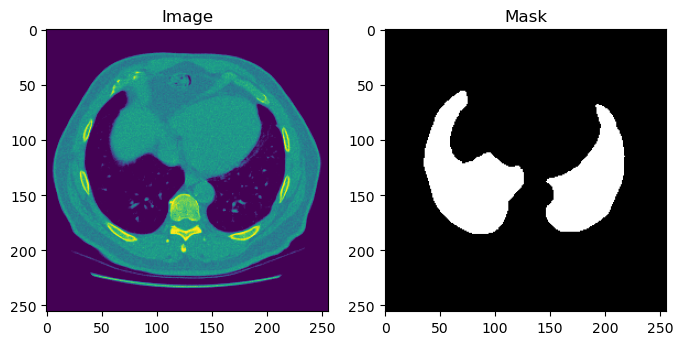

Validation


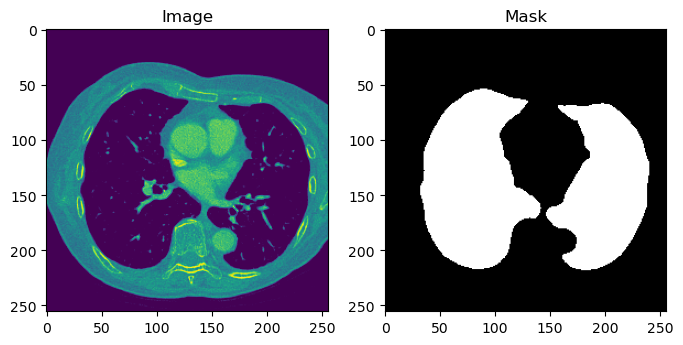

Test


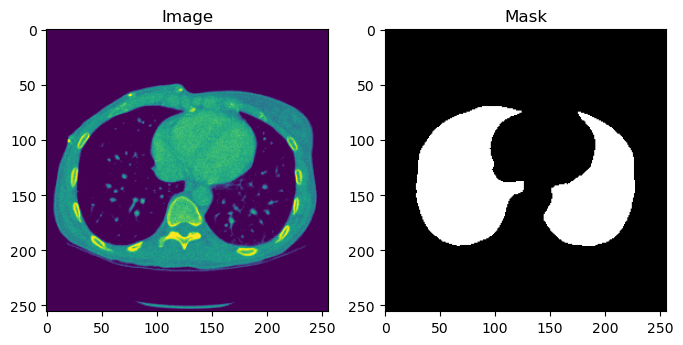

In [25]:
import sys
sys.path.append('..')
from utils import show_sbs
from torch.utils.data import DataLoader, Subset
from torchvision import transforms



# # ------------------- params --------------------
INPUT_SIZE = 256
RAW_DATA_DIR = '/home/staff/azad/deeplearning/datasets/lung/archive/3d_images'
PROCESSED_DATA_DIR = f'{RAW_DATA_DIR}/dataset/lung-2d/processed_data'
FORCE_REPLACE = True
VERBOSE = True
 

TR_BATCH_SIZE = 8
TR_DL_SHUFFLE = True
TR_DL_WORKER = 1

VL_BATCH_SIZE = 12
VL_DL_SHUFFLE = False
VL_DL_WORKER = 1

TE_BATCH_SIZE = 12
TE_DL_SHUFFLE = False
TE_DL_WORKER = 1
# # <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<


# # ----------------- transform ------------------
# transform for image
img_transform = transforms.Compose([
    transforms.Resize(
        size=[INPUT_SIZE, INPUT_SIZE], 
        interpolation=transforms.functional.InterpolationMode.BILINEAR
    ),
])
# transform for mask
msk_transform = transforms.Compose([
    transforms.Resize(
        size=[INPUT_SIZE, INPUT_SIZE], 
        interpolation=transforms.functional.InterpolationMode.NEAREST
    ),
])
# # <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<


# # ----------------- dataset --------------------
# preparing training dataset
tr_dataset = Lung2dDataset(
    processed_data_dir = PROCESSED_DATA_DIR, 
    raw_data_dir = RAW_DATA_DIR, 
    mode = "train",
    verbose = VERBOSE,
    force_replace = FORCE_REPLACE,
    img_transform=img_transform,
    msk_transform=msk_transform
)
print(f"The length of train set is: {len(tr_dataset)}\n")

# preparing test dataset
te_dataset = Lung2dDataset(
    processed_data_dir = PROCESSED_DATA_DIR, 
    raw_data_dir = RAW_DATA_DIR, 
    mode = "test",
    verbose = VERBOSE,
    force_replace = False,
    img_transform=img_transform,
    msk_transform=msk_transform
)
print(f"The length of test set is: {len(te_dataset)}\n")

# preparing validation dataset
vl_dataset = Lung2dDataset(
    processed_data_dir = PROCESSED_DATA_DIR, 
    raw_data_dir = RAW_DATA_DIR, 
    mode = "validation",
    verbose = VERBOSE,
    force_replace = False,
    img_transform=img_transform,
    msk_transform=msk_transform
)
print(f"The length of validation set is: {len(vl_dataset)}\n")



import random
def worker_init_fn(worker_id):
#     random.seed(args.seed + worker_id)
    random.seed(0)


# prepare train dataloader
tr_loader = DataLoader(
    tr_dataset,
    batch_size=TR_BATCH_SIZE, 
    shuffle=TR_DL_SHUFFLE, 
    num_workers=TR_DL_WORKER,
    pin_memory=True,
    worker_init_fn=worker_init_fn
)

# # prepare validation dataloader
vl_loader = DataLoader(
    vl_dataset, 
    batch_size=VL_BATCH_SIZE, 
    shuffle=VL_DL_SHUFFLE, 
    num_workers=VL_DL_WORKER,
    pin_memory=True
)

# prepare test dataloader
te_loader = DataLoader(
    te_dataset, 
    batch_size=TE_BATCH_SIZE, 
    shuffle=TE_DL_SHUFFLE, 
    num_workers=TE_DL_WORKER,
    pin_memory=True
)

# -------------- test -----------------
# test and visualize the input data
for batch in tr_loader:
    print("Training")
    img = batch['image']
    msk = batch['mask']
    data_id = batch['id']
    show_sbs(img[0], msk[0])
    break
    
for batch in vl_loader:
    print("Validation")
    img = batch['image']
    msk = batch['mask']
    data_id = batch['id']
    show_sbs(img[0], msk[0])
    break
    
for batch in te_loader:
    print("Test")
    img = batch['image']
    msk = batch['mask']
    data_id = batch['id']
    show_sbs(img[0], msk[0])
    break